In [249]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

__Densité des médecins__

In [116]:
density = pd.read_csv('data/density.csv',
                      skiprows=4, encoding='latin', skipfooter=1, engine='python')\
            .drop(0, axis=0)\
            .melt(id_vars=['SPECIALITE'])\
            .rename(columns={'SPECIALITE': 'region', 'variable': 'speciality', 'value': 'density'})

# clean speciality column (lower and remove punctuations)
density.loc[:, 'speciality'] = density.loc[:, 'speciality'].str.lower()\
                                      .map(lambda speciality: ''.join(filter(lambda c: c.isalpha() or c.isspace(), speciality)))\
                                      .str.strip()
density.loc[:, 'region'] = density.loc[:, 'region'].str.lower()\
                                  .str.replace('-', ' ')\
                                  .map(lambda zone: ''.join(filter(lambda c: not c.isdigit(), zone)))\
                                  .str.strip()

In [241]:
density.head()

,region,speciality,density
0,france entiere,ensemble des spécialités dexercice,337.9
1,france métropolitaine,ensemble des spécialités dexercice,340.1
2,drom,ensemble des spécialités dexercice,270.4
3,auvergne rhône alpes,ensemble des spécialités dexercice,339.5
4,bourgogne franche comté,ensemble des spécialités dexercice,297.2


__Honoraires des médecins par département__

In [210]:
# Clean "depassement honoraire" per region dataset
replace_mapping = {'anatomocytopathologie': 'anatomie et cytologie pathologiques',
                   'anesthésieréanimation chirurgicale': 'anesthésieréanimation'}
honoraire_dep = pd.read_excel('data/honoraire_per_dep_2017.xls', sheet_name='Spécialistes', encoding='latin',
                             usecols=['Spécialistes', 'DEPASSEMENTS (Euros)', 'DEPARTEMENT'], na_values='nc',)\
                  .dropna()
row_containing_tot = honoraire_dep[honoraire_dep['Spécialistes'].str.contains('TOTAL')].index
honoraire_dep = honoraire_dep.drop(index=row_containing_tot)
honoraire_dep.loc[:, 'Spécialistes'] = honoraire_dep.loc[:, 'Spécialistes'].str.lower()\
                                                    .map(lambda speciality: ''.join(filter(lambda c: c.isalpha() or c.isspace(), speciality)))\
                                                    .str.strip()
for key, item in replace_mapping.items():
    honoraire_dep.loc[:, 'Spécialistes'] = honoraire_dep.loc[:, 'Spécialistes'].str.replace(key, item)

honoraire_dep.loc[:, 'DEPARTEMENT'] = honoraire_dep.loc[:, 'DEPARTEMENT'].str.lower()\
                                  .str.replace('-', ' ')\
                                  .map(lambda zone: ''.join(filter(lambda c: not c.isdigit(), zone)))\
                                  .str.strip()
# honoraire_dep = honoraire_dep.pivot(index='Spécialistes', columns='REGION INSEE', values='DEPASSEMENTS (Euros)')

In [242]:
honoraire_dep.head()

,Spécialistes,DEPARTEMENT,DEPASSEMENTS (Euros)
0,anesthésieréanimation,ain,2548194.45
1,anesthésieréanimation,aisne,388808.16
2,anesthésieréanimation,allier,530489.48
5,anesthésieréanimation,alpes maritimes,11165710.59
6,anesthésieréanimation,ardèche,798986.69


__Répartition de la population par tranches d'age__

In [234]:
population = pd.read_excel('data/estim-pop-dep-sexe-aq-1975-2019.xls', skiprows=4,
                          sheet_name='2017', usecols=list(range(1, 21)), skipfooter=4)\
               .rename(columns={'Unnamed: 1': 'department'}).dropna(subset=['department'])
population.loc[:, 'department'] = population.loc[:, 'department'].str.lower()\
                                  .str.replace('-', ' ')\
                                  .map(lambda zone: ''.join(filter(lambda c: not c.isdigit(), zone)))\
                                  .str.strip()

In [243]:
population.head()

,department,0 à 4 ans,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,30 à 34 ans,35 à 39 ans,40 à 44 ans,45 à 49 ans,50 à 54 ans,55 à 59 ans,60 à 64 ans,65 à 69 ans,70 à 74 ans,75 à 79 ans,80 à 84 ans,85 à 89 ans,90 à 94 ans
0,ain,39532,44621,44591,38959,30145,35691,40544,42670,45105,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239
1,aisne,31488,35191,35324,33021,25493,28739,31382,31770,33457,35024,36758,36161,35470,34257,21930,16437,15109,10744,4858
2,allier,15432,17462,18776,17865,14344,15294,16322,17564,20078,22644,23354,23966,25015,25815,19058,14911,13779,9963,4625
3,alpes de haute provence,7707,8795,9531,8645,6251,7253,8302,8745,9392,11046,11852,11865,11767,12125,9459,7105,5938,4040,2038
4,hautes alpes,7096,8073,8452,7493,5784,6733,7679,8539,8729,9742,10048,10046,10084,9907,7095,5387,4835,3288,1775


__Fusion des trois tables__

In [211]:
df_merge = density.merge(how='inner', right=honoraire_dep, left_on=['speciality', 'region'],
                         right_on=['Spécialistes', 'DEPARTEMENT'])\
                  .drop(labels=['Spécialistes', 'REGION INSEE'], axis=1)

,speciality,density,DEPARTEMENT,DEPASSEMENTS (Euros)
0,anatomie et cytologie pathologiques,0.5,ain,0.0
1,anatomie et cytologie pathologiques,0.9,aisne,0.0
2,anatomie et cytologie pathologiques,4.6,alpes maritimes,187721.2
3,anatomie et cytologie pathologiques,0.0,ardèche,0.0
4,anatomie et cytologie pathologiques,0.0,ariège,0.0


In [219]:
df_merge.DEPARTEMENT.unique()

array(['ain', 'aisne', 'alpes maritimes', 'ardèche', 'ariège', 'aveyron',
       'bouches du rhône', 'creuse', 'haute garonne', 'gironde',
       'hérault', 'ille et vilaine', 'isère', 'loire', 'haute loire',
       'loire atlantique', 'haute marne', 'meuse', 'moselle', 'nord',
       'pyrénées atlantiques', 'bas rhin', 'rhône', 'haute saône',
       'seine maritime', 'var', 'hauts de seine', 'val de marne',
       'guyane', 'allier', 'aube', 'aude', 'calvados', 'charente',
       'charente maritime', 'dordogne', 'doubs', 'drôme', 'finistère',
       'gard', 'indre et loire', 'landes', 'loir et cher', 'loiret',
       'lot et garonne', 'lozère', 'maine et loire', 'manche', 'marne',
       'meurthe et moselle', 'morbihan', 'oise', 'puy de dôme',
       'pyrénées orientales', 'haut rhin', 'saône et loire', 'sarthe',
       'savoie', 'haute savoie', 'seine et marne', 'yvelines', 'somme',
       'tarn', 'tarn et garonne', 'vaucluse', 'vendée', 'vienne',
       'haute vienne', 'essonne', 'g

In [213]:
df_merge.speciality.unique()

array(['anatomie et cytologie pathologiques', 'anesthésieréanimation',
       'chirurgie générale', 'chirurgie maxillofaciale et stomatologie',
       'chirurgie orthopédique et traumatologie', 'chirurgie infantile',
       'chirurgie plastique reconstructrice et esthétique',
       'chirurgie thoracique et cardiovasculaire', 'chirurgie urologique',
       'chirurgie vasculaire', 'chirurgie viscérale et digestive',
       'endocrinologie et métabolisme', 'gériatrie',
       'gynécologie médicale', 'hématologie',
       'gastroentérologie et hépatologie', 'médecine interne',
       'médecine nucléaire', 'néphrologie', 'neurochirurgie',
       'neurologie', 'ophtalmologie', 'pédiatrie', 'pneumologie',
       'psychiatrie', 'radiodiagnostic et imagerie médicale',
       'radiothérapie', 'réanimation médicale', 'rhumatologie'],
      dtype=object)

In [245]:
df_merge = df_merge.merge(how='inner', right=population, left_on='DEPARTEMENT', right_on='department')\
        .drop(labels='DEPARTEMENT', axis=1)

In [258]:
df_merge.head()

,speciality,density,DEPASSEMENTS (Euros),department,0 à 4 ans,5 à 9 ans,10 à 14 ans,15 à 19 ans,20 à 24 ans,25 à 29 ans,...,45 à 49 ans,50 à 54 ans,55 à 59 ans,60 à 64 ans,65 à 69 ans,70 à 74 ans,75 à 79 ans,80 à 84 ans,85 à 89 ans,90 à 94 ans
0,anatomie et cytologie pathologiques,-0.486489,-0.389833,ain,39532,44621,44591,38959,30145,35691,...,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239
1,anesthésieréanimation,-0.089560,0.562715,ain,39532,44621,44591,38959,30145,35691,...,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239
2,chirurgie orthopédique et traumatologie,-0.332128,0.011079,ain,39532,44621,44591,38959,30145,35691,...,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239
3,chirurgie infantile,-0.523242,-0.389833,ain,39532,44621,44591,38959,30145,35691,...,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239
4,chirurgie thoracique et cardiovasculaire,-0.523242,-0.389833,ain,39532,44621,44591,38959,30145,35691,...,46821,45966,40878,37399,35183,25198,17977,15322,10717,5239


__Visualisation__

In [214]:
df_merge['density'] = (df_merge['density'] - df_merge['density'].mean())/df_merge['density'].std()
df_merge['DEPASSEMENTS (Euros)'] = (df_merge['DEPASSEMENTS (Euros)'] - df_merge['DEPASSEMENTS (Euros)'].mean())/df_merge['DEPASSEMENTS (Euros)'].std()

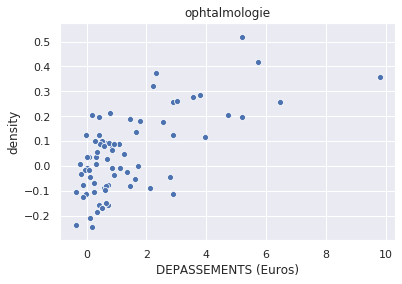

In [257]:
speciality = random.choice(df_merge.speciality.unique())

_ = sns.scatterplot(x='DEPASSEMENTS (Euros)', y='density', data=df_merge[df_merge['speciality'] == speciality])
_ = plt.title(speciality)